The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [1]:
!pip install d2l==0.15.1


#  Sequence to Sequence Learning
:label:`sec_seq2seq`

As we have seen in :numref:`sec_machine_translation`,
in machine translation
both the input and output are a variable-length sequence.
To address this type of problem,
we have designed a general encoder-decoder architecture
in :numref:`sec_encoder-decoder`.
In this section,
we will
use two RNNs to design
the encoder and the decoder of
this architecture
and apply it to *sequence to sequence* learning
for machine translation
:cite:`Sutskever.Vinyals.Le.2014,Cho.Van-Merrienboer.Gulcehre.ea.2014`.

Following the design principle
of the encoder-decoder architecture,
the RNN encoder can
take a variable-length sequence as the input and transforms it into a fixed-shape hidden state.
In other words,
information of the input sequence
is *encoded* in the hidden state of the RNN encoder.
To generate the output sequence token by token,
a separate RNN decoder
can predict the next token based on
what tokens have been seen (such as in language modeling) or generated,
together with the encoded information of the input sequence.
:numref:`fig_seq2seq` illustrates
how to use two RNNs
for sequence to sequence learning
in machine translation.


![Sequence to sequence learning with an RNN encoder and an RNN decoder.](http://d2l.ai/_images/seq2seq.svg)
:label:`fig_seq2seq`

In :numref:`fig_seq2seq`,
the special "&lt;eos&gt;" token
marks the end of the sequence.
The model can stop making predictions
once this token is generated.
At the initial time step of the RNN decoder,
there are two special design decisions.
First, the special beginning-of-sequence "&lt;bos&gt;" token is an input.
Second,
the final hidden state of the RNN encoder is used
to initiate the hidden state of the decoder.
In designs such as :cite:`Sutskever.Vinyals.Le.2014`,
this is exactly
how the encoded input sequence information
is fed into the decoder for generating the output sequence.
In some other designs such as :cite:`Cho.Van-Merrienboer.Gulcehre.ea.2014`,
the final hidden state of the encoder
is also fed into the decoder as
part of the inputs
at every time step as shown in :numref:`fig_seq2seq`.
Similar to the training of language models in
:numref:`sec_language_model`,
we can allow the labels to be the original output sequence,
shifted by one token:
"&lt;bos&gt;", "Ils", "regardent", "." $\rightarrow$
"Ils", "regardent", ".", "&lt;eos&gt;".


In the following,
we will explain the design of :numref:`fig_seq2seq`
in greater details.
We will train this model for machine translation
on the English-French dataset as introduced in
:numref:`sec_machine_translation`.


In [2]:
import collections
from d2l import torch as d2l
import math
import torch
from torch import nn

## Set up Dataset

In [3]:
import pandas as pd
# import glob
import os

data = []
# for csv in glob.glob(os.getcwd() + "/*.csv"):
with open('/content/train.csv', 'r') as f:
    data.extend(f.readlines()[1:])

df_test = pd.read_csv(os.getcwd() + "/test.csv", sep='\t', encoding='utf-8')  

YueChar = True
# Delete spaces between vocabs in Cantonese
# Perform Character based tokenization
if YueChar:
  for i in range(len(data)):
    pair = data[i].split('\t')
    pair[0] = pair[0].replace(' ', '')
    data[i] = '\t'.join(p for p in pair)
  df_test['yue'] = df_test['yue'].str.replace(r' ', '')

data = ''.join(x for x in data)
print('\n'.join(x for x in data.splitlines()[:5]))

唔準掂同食醃菜唔準坐梳化或者屋企人嘅床上每次經期完咗要洗床單就算床單無汚糟到他們認為我唔純潔禁止我參拜或者掂一啲聖物你會發現寺廟出面有牌路牌禁止正在嚟緊經期嘅婦女進入	I was not allowed to touch or eat pickles I was not allowed to sit on the sofa or some other family member s bed I had to wash my bed sheet after every period even if it was not stained I was considered impure and forbidden from worshipping or touching any object of religious importance You ll find signposts outside temples denying the entry of menstruating girls and women
佢地扮怪面嚇人	They were making scary faces
唔會搞到我哋變得邪惡女人型變成自由黨人咩	turn us into godless sissy liberals
呢個模式可以清晰令您瞭解佢哋	So it spells those out in very clean terms
幾多萬億掌聲	How many trillions Applause


In [4]:
import regex as re
def spliteKeyWord(str):
    regex = r"[\u4e00-\ufaff]|[0-9]+|[a-zA-Z]+\'*[a-z]*"
    matches = re.findall(regex, str, re.UNICODE)
    return ' '.join(matches)

if YueChar:
    # df['yue'] = df['yue'].apply(lambda x: spliteKeyWord(x))
    df_test['yue'] = df_test['yue'].apply(lambda x: spliteKeyWord(x))
df_test.head()

,yue,eng
0,我 相 信 主,I believe the almighty
1,好 耐 以 嚟 有 發 展 紊 亂 嘅 小 朋 友,For too long now children with developmental d...
2,一 般 會 遇 到 兩 種 反 應,I have two kinds of reactions
3,但 再 諗 下 嗰 位 官 員 未 必 係 唯 一 睇 小 女 性 嘅 人 呢 種 偏 見 ...,But think about this The IMF official is hardl...
4,佢 將 呢 個 病 毒 傳 畀 BB,She passes that virus on to baby


In [5]:
inp_lang = 'yue'
tar_lang = 'eng'
# direction = 'eng2yue'
direction = 'yue2eng'

In [6]:
#@save
def tokenize_nmt(text, num_steps, direction, YueChar, num_examples=None):
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples and i > num_examples:
            break
        parts = line.split('\t')
        if len(parts) == 2:
            yue = [w for w in parts[0]] if YueChar else parts[0].split(' ')
            eng = parts[1].split(' ')
            if len(yue) < num_steps and len(eng) < num_steps:
              if direction == 'yue2eng':
                source.append(yue)
                target.append(eng)
              else:
                source.append(eng)
                target.append(yue)
    return source, target
num_steps = 20
inp, tar = tokenize_nmt(data, num_steps, direction, YueChar)
print('Total size:', len(inp), '\n')
inp[:6], tar[:6]

Total size: 6603 



([['佢', '地', '扮', '怪', '面', '嚇', '人'],
  ['呢', '個', '模', '式', '可', '以', '清', '晰', '令', '您', '瞭', '解', '佢', '哋'],
  ['幾', '多', '萬', '億', '掌', '聲'],
  ['但', '從', '此', '以', '後', '事', '情', '越', '嚟', '越', '複', '雜'],
  ['紐', '約'],
  ['我', '無', '啦', '啦', '記', '返', '我', '爺', '爺', '教', '過', '我', '嘅', '嘢']],
 [['They', 'were', 'making', 'scary', 'faces'],
  ['So', 'it', 'spells', 'those', 'out', 'in', 'very', 'clean', 'terms'],
  ['How', 'many', 'trillions', 'Applause'],
  ['But',
   'and',
   'this',
   'of',
   'course',
   'is',
   'where',
   'it',
   'becomes',
   'complicated'],
  ['New', 'York'],
  ['I',
   'cannot',
   'help',
   'but',
   'remember',
   'my',
   'grandfather',
   's',
   'lesson']])

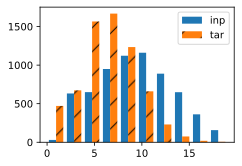

In [7]:
d2l.set_figsize()
_, _, patches = d2l.plt.hist(
    [[len(l) for l in inp], [len(l) for l in tar]],
    label=['inp', 'tar'])
for patch in patches[1].patches:
    patch.set_hatch('/')
d2l.plt.legend(loc='upper right');

In [8]:
src_vocab = d2l.Vocab(inp, min_freq=2,
                      reserved_tokens=['<pad>', '<bos>', '<eos>'])
tar_vocab = d2l.Vocab(tar, min_freq=2,
                      reserved_tokens=['<pad>', '<bos>', '<eos>'])
print('Input vocab size:', len(src_vocab))
print('Target vocab size:', len(tar_vocab))

Input vocab size: 1911
Target vocab size: 2756


In [9]:
#@save
def truncate_pad(line, num_steps, padding_token):
    """Truncate or pad sequences."""
    if len(line) > num_steps:
        return line[:num_steps]  # Truncate
    return line + [padding_token] * (num_steps - len(line))  # Pad

truncate_pad(src_vocab[inp[0]], 10, src_vocab['<pad>'])

[15, 39, 977, 760, 79, 899, 12, 1, 1, 1]

In [10]:
#@save
def build_array_nmt(lines, vocab, num_steps):
    """Transform text sequences of machine translation into minibatches."""
    lines = [vocab[l] for l in lines]
    lines = [l + [vocab['<eos>']] for l in lines]
    array = torch.tensor([truncate_pad(
        l, num_steps, vocab['<pad>']) for l in lines])
    valid_len = d2l.reduce_sum(
        d2l.astype(array != vocab['<pad>'], torch.int32), 1)
    return array, valid_len

In [11]:
#@save
def load_data_nmt(text, batch_size, num_steps, num_examples=None):
    source, target = tokenize_nmt(text, num_steps, direction, num_examples)
    src_vocab = d2l.Vocab(source, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = d2l.Vocab(target, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = d2l.load_array(data_arrays, batch_size)
    return data_iter, src_vocab, tgt_vocab

## Encoder

Technically speaking,
the encoder transforms an input sequence of variable length into a fixed-shape *context variable* $\mathbf{c}$, and encodes the input sequence information in this context variable.
As depicted in :numref:`fig_seq2seq`,
we can use an RNN to design the encoder.

Let us consider a sequence example (batch size: 1).
Suppose that
the input sequence is $x_1, \ldots, x_T$, such that $x_t$ is the $t^{\mathrm{th}}$ token in the input text sequence.
At time step $t$, the RNN transforms
the input feature vector $\mathbf{x}_t$ for $x_t$
and the hidden state $\mathbf{h} _{t-1}$ from the previous time step
into the current hidden state $\mathbf{h}_t$.
We can use a function $f$ to express the transformation of the RNN's recurrent layer:

$$\mathbf{h}_t = f(\mathbf{x}_t, \mathbf{h}_{t-1}). $$

In general,
the encoder transforms the hidden states at
all the time steps
into the context variable through a customized function $q$:

$$\mathbf{c} =  q(\mathbf{h}_1, \ldots, \mathbf{h}_T).$$

For example, when choosing $q(\mathbf{h}_1, \ldots, \mathbf{h}_T) = \mathbf{h}_T$ such as in :numref:`fig_seq2seq`,
the context variable is just the hidden state $\mathbf{h}_T$
of the input sequence at the final time step.

So far we have used a unidirectional RNN
to design the encoder,
where
a hidden state only depends on
the input subsequence at and before the time step of the hidden state.
We can also construct encoders using bidirectional RNNs. In this case, a hidden state depends on
the subsequence before and after the time step (including the input at the current time step), which encodes the information of the entire sequence.


Now let us implement the RNN encoder.
Note that we use an *embedding layer*
to obtain the feature vector for each token in the input sequence.
The weight
of an embedding layer
is a matrix
whose number of rows equals to the size of the input vocabulary (`vocab_size`)
and number of columns equals to the feature vector's dimension (`embed_size`).
For any input token index $i$,
the embedding layer
fetches the $i^{\mathrm{th}}$ row (starting from 0) of the weight matrix
to return its feature vector.
Besides,
here we choose a multilayer GRU to
implement the encoder.


In [12]:
#@save
class Seq2SeqEncoder(d2l.Encoder):
    """The RNN encoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers,
                          dropout=dropout)

    def forward(self, X, *args):
        # The output `X` shape: (`batch_size`, `num_steps`, `embed_size`)
        X = self.embedding(X)
        # In RNN models, the first axis corresponds to time steps
        X = X.permute(1, 0, 2)
        # When state is not mentioned, it defaults to zeros
        output, state = self.rnn(X)
        # `output` shape: (`num_steps`, `batch_size`, `num_hiddens`)
        # `state` shape: (`num_layers`, `batch_size`, `num_hiddens`)
        return output, state

The returned variables of recurrent layers
have been explained in :numref:`sec_rnn-concise`.
Let us still use a concrete example
to illustrate the above encoder implementation.
Below
we instantiate a two-layer GRU encoder
whose number of hidden units is 16.
Given
a minibatch of sequence inputs `X`
(batch size: 4, number of time steps: 7),
the hidden states of the last layer
at all the time steps
(`output` return by the encoder's recurrent layers)
are a tensor
of shape
(number of time steps, batch size, number of hidden units).


In [13]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
encoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)
output, state = encoder(X)
output.shape

torch.Size([7, 4, 16])

Since a GRU is employed here,
the shape of the multilayer hidden states
at the final time step
is
(number of hidden layers, batch size, number of hidden units).
If an LSTM is used,
memory cell information will also be contained in `state`.


In [14]:
state.shape

torch.Size([2, 4, 16])

## Decoder
:label:`sec_seq2seq_decoder`

As we just mentioned,
the context variable $\mathbf{c}$ of the encoder's output encodes the entire input sequence $x_1, \ldots, x_T$. Given the output sequence $y_1, y_2, \ldots, y_{T'}$ from the training dataset,
for each time step $t'$
(the symbol differs from the time step $t$ of input sequences or encoders),
the probability of the decoder output $y_{t'}$
is conditional
on the previous output subsequence
$y_1, \ldots, y_{t'-1}$ and
the context variable $\mathbf{c}$, i.e., $P(y_{t'} \mid y_1, \ldots, y_{t'-1}, \mathbf{c})$.

To model this conditional probability on sequences,
we can use another RNN as the decoder.
At any time step $t^\prime$ on the output sequence,
the RNN takes the output $y_{t^\prime-1}$ from the previous time step
and the context variable $\mathbf{c}$ as its input,
then transforms
them and
the previous hidden state $\mathbf{s}_{t^\prime-1}$
into the
hidden state $\mathbf{s}_{t^\prime}$ at the current time step.
As a result, we can use a function $f$ to express the transformation of the decoder's hidden layer:

$$\mathbf{s}_{t^\prime} = g(y_{t^\prime-1}, \mathbf{c}, \mathbf{s}_{t^\prime-1}).$$

After obtaining the hidden state of the decoder,
we can use an output layer and the softmax operation to compute the conditional probability distribution
$P(y_{t^\prime} \mid y_1, \ldots, y_{t^\prime-1}, \mathbf{c})$ for the output at time step $t^\prime$.

Following :numref:`fig_seq2seq`,
when implementing the decoder as follows,
we directly use the hidden state at the final time step
of the encoder
to initialize the hidden state of the decoder.
This requires that the RNN encoder and the RNN decoder have the same number of layers and hidden units.
To further incorporate the encoded input sequence information,
the context variable is concatenated
with the decoder input at all the time steps.
To predict the probability distribution of the output token,
a fully-connected layer is used to transform
the hidden state at the final layer of the RNN decoder.


In [15]:
class Seq2SeqDecoder(d2l.Decoder):
    """The RNN decoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers,
                          dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]

    def forward(self, X, state):
        # The output `X` shape: (`num_steps`, `batch_size`, `embed_size`)
        X = self.embedding(X).permute(1, 0, 2)
        # Broadcast `context` so it has the same `num_steps` as `X`
        context = state[-1].repeat(X.shape[0], 1, 1)
        X_and_context = torch.cat((X, context), 2)
        output, state = self.rnn(X_and_context, state)
        output = self.dense(output).permute(1, 0, 2)
        # `output` shape: (`batch_size`, `num_steps`, `vocab_size`)
        # `state` shape: (`num_layers`, `batch_size`, `num_hiddens`)
        return output, state

To illustrate the implemented decoder,
below we instantiate it with the same hyperparameters from the aforementioned encoder.
As we can see, the output shape of the decoder becomes (batch size, number of time steps, vocabulary size),
where the last dimension of the tensor stores the predicted token distribution.


In [16]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
decoder.eval()
state = decoder.init_state(encoder(X))
output, state = decoder(X, state)
output.shape, state.shape

(torch.Size([4, 7, 10]), torch.Size([2, 4, 16]))

To summarize,
the layers in the above RNN encoder-decoder model are illustrated in :numref:`fig_seq2seq_details`.

![Layers in an RNN encoder-decoder model.](https://github.com/d2l-ai/d2l-pytorch-colab/blob/master/img/seq2seq-details.svg?raw=1)
:label:`fig_seq2seq_details`

## Loss Function

At each time step, the decoder
predicts a probability distribution for the output tokens.
Similar to language modeling,
we can apply softmax to obtain the distribution
and calculate the cross-entropy loss for optimization.
Recall :numref:`sec_machine_translation`
that the special padding tokens
are appended to the end of sequences
so sequences of varying lengths
can be efficiently loaded
in minibatches of the same shape.
However,
prediction of padding tokens
should be excluded from loss calculations.

To this end,
we can use the following
`sequence_mask` function
to mask irrelevant entries with zero values
so later
multiplication of any irrelevant prediction
with zero equals to zero.
For example,
if the valid length of two sequences
excluding padding tokens
are one and two, respectively,
the remaining entries after
the first one
and the first two entries are cleared to zeros.


In [17]:
#@save
def sequence_mask(X, valid_len, value=0):
    """Mask irrelevant entries in sequences."""
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32,
                        device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X

X = torch.tensor([[1, 2, 3], [4, 5, 6]])
sequence_mask(X, torch.tensor([1, 2]))

tensor([[1, 0, 0],
        [4, 5, 0]])

We can also mask all the entries across the last
few axes.
If you like, you may even specify
to replace such entries with a non-zero value.


In [18]:
X = torch.ones(2, 3, 4)
sequence_mask(X, torch.tensor([1, 2]), value=-1)

tensor([[[ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.]],

        [[ 1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.]]])

Now we can extend the softmax cross-entropy loss
to allow the masking of irrelevant predictions.
Initially,
masks for all the predicted tokens are set to one.
Once the valid length is given,
the mask corresponding to any padding token
will be cleared to zero.
In the end,
the loss for all the tokens
will be multipled by the mask to filter out
irrelevant predictions of padding tokens in the loss.


In [19]:
#@save
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """The softmax cross-entropy loss with masks."""
    # `pred` shape: (`batch_size`, `num_steps`, `vocab_size`)
    # `label` shape: (`batch_size`, `num_steps`)
    # `valid_len` shape: (`batch_size`,)
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        weights = sequence_mask(weights, valid_len)
        self.reduction='none'
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(
            pred.permute(0, 2, 1), label)
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        return weighted_loss

For a sanity check, we can create three identical sequences.
Then we can
specify that the valid lengths of these sequences
are 4, 2, and 0, respectively.
As a result,
the loss of the first sequence
should be twice as large as that of the second sequence,
while the third sequence should have a zero loss.


In [20]:
loss = MaskedSoftmaxCELoss()
loss(torch.ones(3, 4, 10), torch.ones((3, 4), dtype=torch.long),
     torch.tensor([4, 2, 0]))

tensor([2.3026, 1.1513, 0.0000])

## Training
:label:`sec_seq2seq_training`

In the following training loop,
we concatenate the special beginning-of-sequence token
and the original output sequence excluding the final token as
the input to the decoder, as shown in :numref:`fig_seq2seq`.
This is called *teacher forcing* because
the original output sequence (token labels) is fed into the decoder.
Alternatively,
we could also feed the *predicted* token
from the previous time step
as the current input to the decoder.


In [21]:
#@save
def train_s2s_ch9(model, data_iter, lr, num_epochs, tgt_vocab, device):
    """Train a model for sequence to sequence (defined in Chapter 9)."""
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    torch.nn.init.xavier_uniform_(m._parameters[param])
    model.apply(xavier_init_weights)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    model.train()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[0, num_epochs])
    for epoch in range(num_epochs):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)  # Sum of training loss, no. of tokens
        for batch in data_iter:
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                               device=device).reshape(-1, 1)
            dec_input = torch.cat([bos, Y[:, :-1]], 1)  # Teacher forcing
            Y_hat, _ = model(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()  # Make the loss scalar for `backward`
            d2l.grad_clipping(model, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        if (epoch + 1) % 1 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
        end = timer.stop()
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / end:.1f} '
          f'tokens/sec on {str(device)}')
    # print(f'Training time: {end}')

Now we can create and train an RNN encoder-decoder model
for sequence to sequence learning on the machine translation dataset.


loss 0.293, 4762.9 tokens/sec on cuda:0


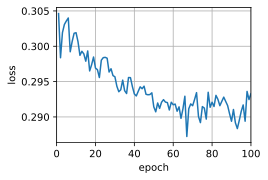

In [22]:
embed_size, num_hiddens, num_layers, dropout = 256, 512, 8, 0.4
batch_size, num_steps = 64, 20
lr, num_epochs, device = 0.005, 100, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = load_data_nmt(data, batch_size, num_steps)
encoder = Seq2SeqEncoder(
    len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(
    len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = d2l.EncoderDecoder(encoder, decoder)
train_s2s_ch9(model, train_iter, lr, num_epochs, tgt_vocab, device)

In [23]:
print(model)

EncoderDecoder(
  (encoder): Seq2SeqEncoder(
    (embedding): Embedding(62, 256)
    (rnn): GRU(256, 512, num_layers=8, dropout=0.4)
  )
  (decoder): Seq2SeqDecoder(
    (embedding): Embedding(2866, 256)
    (rnn): GRU(768, 512, num_layers=8, dropout=0.4)
    (dense): Linear(in_features=512, out_features=2866, bias=True)
  )
)


## Prediction

To predict the output sequence
token by token,
at each decoder time step
the predicted token from the previous
time step is fed into the decoder as an input.
Similar to training,
at the initial time step
the beginning-of-sequence ("&lt;bos&gt;") token
is fed into the decoder.
This prediction process
is illustrated in :numref:`fig_seq2seq_predict`.
When the end-of-sequence ("&lt;eos&gt;") token is predicted,
the prediction of the output sequence is complete.


![Predicting the output sequence token by token using an RNN encoder-decoder.](https://github.com/d2l-ai/d2l-pytorch-colab/blob/master/img/seq2seq-predict.svg?raw=1)
:label:`fig_seq2seq_predict`

We will introduce different
strategies for sequence generation in
:numref:`sec_beam-search`.


In [24]:
#@save
def predict_s2s_ch9(model, src_sentence, src_vocab, tgt_vocab, num_steps, direction, YueChar,
                    device):
    if YueChar and direction == 'yue2eng':
        src_tokens = src_vocab[[w for w in src_sentence]] + [
            src_vocab['<eos>']]
    else:
      src_tokens = src_vocab[src_sentence.lower().split(' ')] + [
          src_vocab['<eos>']]
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = d2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    # Add the batch axis
    enc_X = torch.unsqueeze(
        torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    enc_outputs = model.encoder(enc_X, enc_valid_len)
    dec_state = model.decoder.init_state(enc_outputs, enc_valid_len)
    # Add the batch axis
    dec_X = torch.unsqueeze(torch.tensor(
        [tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0)
    output_seq = []
    for _ in range(num_steps):
        Y, dec_state = model.decoder(dec_X, dec_state)
        # We use the token with the highest prediction likelihood as the input
        # of the decoder at the next time step
        dec_X = Y.argmax(dim=2)
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        # Once the end-of-sequence token is predicted, the generation of
        # the output sequence is complete
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq))

## Evaluation of Predicted Sequences

We can evaluate a predicted sequence
by comparing it with the
label sequence (the ground-truth).
BLEU (Bilingual Evaluation Understudy),
though originally proposed for evaluating
machine translation results :cite:`Papineni.Roukos.Ward.ea.2002`,
has been extensively used in measuring
the quality of output sequences for different applications.
In principle, for any $n$-grams in the predicted sequence,
BLEU evaluates whether this $n$-grams appears
in the label sequence.

Denote by $p_n$
the precision of $n$-grams,
which is
the ratio of
the number of matched $n$-grams in
the predicted and label sequences
to
the number of $n$-grams in the predicted sequence.
To explain,
given a label sequence $A$, $B$, $C$, $D$, $E$, $F$,
and a predicted sequence $A$, $B$, $B$, $C$, $D$.
We have $p_1 = 4/5$,  $p_2 = 3/4$, $p_3 = 1/3$, and $p_4 = 0$.
Besides,
let $\mathrm{len}_{\text{label}}$ and $\mathrm{len}_{\text{pred}}$
be
the numbers of tokens in the label sequence and the predicted sequence, respectively.
Then, BLEU is defined as

$$ \exp\left(\min\left(0, 1 - \frac{\mathrm{len}_{\text{label}}}{\mathrm{len}_{\text{pred}}}\right)\right) \prod_{n=1}^k p_n^{1/2^n},$$
:eqlabel:`eq_bleu`

where $k$ is the longest $n$-grams for matching.

Based on the definition of BLEU in :eqref:`eq_bleu`,
whenever the predicted sequence is the same as the label sequence, BLEU is 1.
Moreover,
since matching longer $n$-grams is more difficult,
BLEU assigns a greater weight
to a longer $n$-gram precision.
Specifically, when $p_n$ is fixed,
$p_n^{1/2^n}$ increases as $n$ grows.
Furthermore,
since
predicting shorter sequences
tends to obtain a higher $p_n$ value,
the coefficient before the multiplication term in :eqref:`eq_bleu`
penalizes shorter predicted sequences.
For example, when $k=2$,
given the label sequence $A$, $B$, $C$, $D$, $E$, $F$ and the predicted sequence $A$, $B$,
although $p_1 = p_2 = 1$, the penalty factor $\exp(1-6/2) \approx 0.14$ lowers the BLEU.

We implement the BLEU measure as follows.


In [25]:
def bleu(pred_seq, label_seq, k):  #@save
    """Compute the BLEU."""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[''.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[''.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[''.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

In the end,
we use the trained RNN encoder-decoder
to translate a few English sentences into French
and compute the BLEU of the results.


In [26]:
#@save
def translate(inp, tar, model, src_vocab, tgt_vocab, num_steps, direction, YueChar, device):
    # for inp, tar in zip(inp, tar):
    translation = predict_s2s_ch9(
        model, inp, src_vocab, tgt_vocab, num_steps, direction, YueChar, device)
    print(
        f'{inp} => {translation}')
        # f'{inp} => {translation}, bleu {bleu(translation, tar, k=2):.3f}')

In [27]:
import random
ran = random.randint(1, len(inp))
print(' '.join(inp[ran]))
print(' '.join(tar[ran]))
print()

# translate(inp[ran], tar[ran], model, src_vocab, tgt_vocab, num_steps, direction[0], True, device)

translate(' '.join(inp[ran]), ' '.join(tar[ran]), model, src_vocab, tgt_vocab, num_steps, direction, True, device)

好 似 去 S i z z l e r 噉
and like go to Sizzler

好 似 去 S i z z l e r 噉 => Laughter


In [28]:
import time
TotalTime = time.time()
start = time.time()

ori = []
ref = []
can = []
num_test = 0

for index, row in df_test.iterrows():
    inp = row[inp_lang]
    tar = row[tar_lang]
    num_test += 1
    pre = predict_s2s_ch9(model, inp, src_vocab, tgt_vocab, num_steps, direction, YueChar, device)
    ori.append(inp)
    ref.append(tar)
    if YueChar:
        can.append(spliteKeyWord(pre))
    else:
        can.append(pre)
    if num_test % 50 == 0:
        print(f'Progress: {num_test} / {len(df_test)} in {time.time()-start} s')
        start = time.time()
        
print(f'\nToTal: {num_test} / {len(df_test)} in {time.time()-TotalTime} s')

Progress: 50 / 1963 in 0.4368710517883301 s
Progress: 100 / 1963 in 0.4380779266357422 s
Progress: 150 / 1963 in 0.4337592124938965 s
Progress: 200 / 1963 in 0.4323279857635498 s
Progress: 250 / 1963 in 0.4330601692199707 s
Progress: 300 / 1963 in 0.43104100227355957 s
Progress: 350 / 1963 in 0.42852330207824707 s
Progress: 400 / 1963 in 0.4444136619567871 s
Progress: 450 / 1963 in 0.44002652168273926 s
Progress: 500 / 1963 in 0.4426295757293701 s
Progress: 550 / 1963 in 0.435985803604126 s
Progress: 600 / 1963 in 0.44272899627685547 s
Progress: 650 / 1963 in 0.45087480545043945 s
Progress: 700 / 1963 in 0.44009947776794434 s
Progress: 750 / 1963 in 0.4338688850402832 s
Progress: 800 / 1963 in 0.43543481826782227 s
Progress: 850 / 1963 in 0.4427478313446045 s
Progress: 900 / 1963 in 0.44805240631103516 s
Progress: 950 / 1963 in 0.44167327880859375 s
Progress: 1000 / 1963 in 0.44741058349609375 s
Progress: 1050 / 1963 in 0.45584774017333984 s
Progress: 1100 / 1963 in 0.4421534538269043 

In [ ]:
import nltk
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction
smoothie = SmoothingFunction().method4

import random
ran = random.randint(1, len(ref))
print(ori[ran])
print(ref[ran])
print(can[ran])

print('BLEU:', sentence_bleu(ref[ran], can[ran], smoothing_function=smoothie)*100)

In [30]:
# Sentence-based and average score
# score = 0
# for i in range(len(ref)):
#     r = [ref[i].split()]
#     c = can[i].split()
#     score += sentence_bleu(r, c, smoothing_function=smoothie)*100
# print('BLEU-s:', score/len(ref))

# Corpus based, summing all nominator and denominator before division
r = [[r.split()] for r in ref]
c = [c.split() for c in can]
score = corpus_bleu(r, c, smoothing_function=smoothie)*100
print('BLEU-c:', score)

BLEU-c: 0.22894459189194846
BLEU-c: 0.22894459189194846


## Summary

* Following the design of the encoder-decoder architecture, we can use two RNNs to design a model for sequence to sequence learning.
* When implementing the encoder and the decoder, we can use multilayer RNNs.
* We can use masks to filter out irrelevant computations, such as when calculating the loss.
* In encoder-decoder training, the teacher forcing approach feeds original output sequences (in contrast to predictions) into the decoder.
* BLEU is a popular measure for evaluating output sequences by matching $n$-grams between the predicted sequence and the label sequence.


## Exercises

1. Can you adjust the hyperparameters to improve the translation results?
1. Rerun the experiment without using masks in the loss calculation. What results do you observe? Why?
1. If the encoder and the decoder differ in the number of layers or the number of hidden units, how can we initialize the hidden state of the decoder?
1. In training, replace teacher forcing with feeding the prediction at the previous time step into the decoder. How does this influence the performance?
1. Rerun the experiment by replacing GRU with LSTM.
1. Are there any other ways to design the output layer of the decoder?


[Discussions](https://discuss.d2l.ai/t/1062)
